# Importing MajorTOM-Core

In [ ]:
!pip install leafmap datasets git+https://github.com/ESA-PhiLab/Major-TOM.git
import pandas as pd

In [ ]:
from pathlib import Path
import urllib.request
from majortom import *

SOURCE_DATASET = 'Major-TOM/Core-S2L2A' # Identify HF Dataset
DATASET_DIR = Path('./data/Major-TOM/')
DATASET_DIR.mkdir(exist_ok=True, parents=True)
ACCESS_URL = 'https://huggingface.co/datasets/{}/resolve/main/metadata.parquet?download=true'.format(SOURCE_DATASET)
LOCAL_URL = DATASET_DIR / '{}.parquet'.format(ACCESS_URL.split('.parquet')[0].split('/')[-1])

# download from server to local url
gdf = metadata_from_url(ACCESS_URL, LOCAL_URL)

# pandas and pyarrow are compatible
#gdf.to_parquet(DATASET_DIR / 'metadata.parquet', index=False)
#gdf = metadata_from_url(ACCESS_URL, LOCAL_URL)

gdf.head()

In [ ]:
def get_tile_thumbnail(row):
  filter_download(gdf.iloc[row: row+1], local_dir='./data/', source_name='L2A', by_row=True)
  ds = MajorTOM(gdf.iloc[row: row+1], './data/L2A')
  return ds[0]['thumbnail']


# Gettting the FNF4 dataset

In [ ]:
import os
import ee
import geemap
import numpy as np

In [ ]:
geemap.Map()

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
fnf_images = {2017: ee.Image('JAXA/ALOS/PALSAR/YEARLY/FNF4/2017').select('fnf'),
              2018: ee.Image('JAXA/ALOS/PALSAR/YEARLY/FNF4/2018').select('fnf'),
              2019: ee.Image('JAXA/ALOS/PALSAR/YEARLY/FNF4/2019').select('fnf'),
              2020: ee.Image('JAXA/ALOS/PALSAR/YEARLY/FNF4/2020').select('fnf'),
              }

In [ ]:
import datetime
def get_closest_fnf_image(timestamp):
  year = timestamp.year
  year = max(min(year, 2020), 2017)
  # print(timestamp, year)
  return fnf_images[year]

In [ ]:
def get_forest_ratio(lat1, long1, lat2, long2, timestamp, debug = False):
    '''
    Determines forest ratio given opposing corners of a bounding box
    '''
    north, west, south, east = lat1, long1, lat2, long2
    rectangle = ee.Geometry.BBox(west, south, east, north);
    image = get_closest_fnf_image(timestamp)
    clipped_image = image.clip(rectangle)

    # manually calcuate approximate total number of pixels from coordinates given 1 pixel per 25 meters^2
    width_meters = abs(long2 - long1) * 111111
    height_meters = abs(lat2 - lat1) * 111111
    total_pixels = math.ceil(width_meters * height_meters / (25*25))

    if debug:
      map = geemap.Map()

    # Define a server-side function to count zero pixels.
    def calculate_forest_ratio(image):
      one_mask = image.select('fnf').eq(1)
      two_mask = image.select('fnf').eq(2)
      if debug:
        three_mask = image.select('fnf').eq(3)
        four_mask = image.select('fnf').eq(4)
        map.addLayer(one_mask, name='dense forest')
        map.addLayer(two_mask, name='non-dense forest')
        map.addLayer(three_mask, name='non-forest land')
        map.addLayer(four_mask, name='water')

      one_pixels = one_mask.reduceRegion(reducer=ee.Reducer.sum(), geometry=image.geometry(), scale=25).get('fnf')
      two_pixels = two_mask.reduceRegion(reducer=ee.Reducer.sum(), geometry=image.geometry(), scale=25).get('fnf')

      # add all the ComputedObjects together. + operator doesn't work
      forest_pixels = ee.Number(one_pixels).add(two_pixels).getInfo()

      ratio = min(forest_pixels/total_pixels, 1)

      if debug:
        print('total pixels:',total_pixels)
        print('forest pixels:',forest_pixels)
      return ratio

    ratio = calculate_forest_ratio(clipped_image)

    # #uniques, counts = np.unique(geemap.ee_to_numpy(clipped_image, region = rectangle), return_counts=True)
    # counts_1 = np.count_nonzero(clipped_image_numpy == 1)
    # counts_2 = np.count_nonzero(clipped_image_numpy == 2)
    # counts_3 = np.count_nonzero(clipped_image_numpy == 3)
    # counts_4 = np.count_nonzero(clipped_image_numpy == 4)
    # total = counts_1 + counts_2 + counts_3 + counts_4
    # if total == 0:
    #     ratio = 0
    # else:
    #     ratio = (counts_1 + counts_2) / total
    if debug:
      map.addLayer(clipped_image)
      map.addLayer(rectangle)
      map.centerObject(rectangle)
      return ratio, map
    else:
      return ratio

# Checking out the data

In [ ]:
print(gdf.grid_row_u.min(), gdf.grid_row_u.max(), gdf.grid_col_r.min(), gdf.grid_col_r.max())

-922 920 -1984 1993


In [ ]:
print(gdf.timestamp.min(), gdf.timestamp.max(), gdf.timestamp.median())

2016-01-01 00:02:42 2024-02-06 02:43:21 2021-04-09 07:06:21


In [ ]:
len(gdf)

2245886

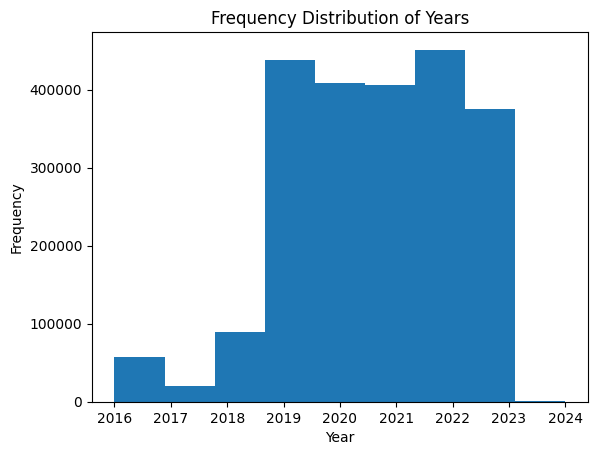

In [ ]:
# prompt: plot a frequency distribution of years in the gdf.timestamps

import matplotlib.pyplot as plt

# Extract years from timestamps
years = gdf.timestamp.dt.year
# Plot frequency distribution
plt.hist(years, bins=years.unique().size)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Years')
plt.show()


In [ ]:
print(years.value_counts())
print(years.count())

timestamp
2022    451209
2019    438284
2020    408384
2021    406358
2023    374908
2018     88773
2016     56950
2017     20552
2024       468
Name: count, dtype: int64
2245886


In [ ]:
min_row, max_row, min_col, max_col = gdf.grid_row_u.min(), gdf.grid_row_u.max(), gdf.grid_col_r.min(), gdf.grid_col_r.max()

# Detetrmining Forest Percentage of a tile in MajorTOM dataset

In [ ]:
import math

# Constants
R_EARTH = 6378.137  # Radius of the Earth in km (WGS84 equatorial radius)
D = 10.0  # Nominal grid spacing in km

def calculate_bounding_box(center_lat, center_lon, row, col):
    N_r = math.ceil(math.pi * R_EARTH / D)
    delta_lat = 180 / N_r
    row_lat = row * delta_lat
    C_r = 2 * math.pi * R_EARTH * math.cos(math.radians(row_lat))
    N_c = math.ceil(C_r / D)
    delta_lon = 360 / N_c

    # Step 8: Calculate bounding box corners
    top_left_lat = center_lat + delta_lat / 2
    top_left_lon = center_lon - delta_lon / 2
    bottom_right_lat = center_lat - delta_lat / 2
    bottom_right_lon = center_lon + delta_lon / 2

    return (top_left_lat, top_left_lon), (bottom_right_lat, bottom_right_lon)

In [ ]:
# test 1

(lat1, lon1), (lat2, lon2) = calculate_bounding_box(gdf['centre_lat'].iloc[0], gdf['centre_lon'].iloc[0], gdf['grid_row_u'].iloc[0], gdf['grid_col_r'].iloc[0])
print(lat1, lon1, lat2, lon2)
r, map = get_forest_ratio(lat1, lon1, lat2, lon2, gdf['timestamp'].iloc[0], True)
print('ratio:' + str(r))
map

-82.72575622195403 -178.5588964086367 -82.81557658123548 -177.8417649345331
total pixels: 1272354
forest pixels: 0
ratio:0.0


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# test 2
row = 2235340
(lat1, lon1), (lat2, lon2) = calculate_bounding_box(gdf['centre_lat'].iloc[row], gdf['centre_lon'].iloc[row], gdf['grid_row_u'].iloc[row], gdf['grid_col_r'].iloc[row])
print(lat1, lon1, lat2, lon2)
r, map = get_forest_ratio(lat1, lon1, lat2, lon2, gdf['timestamp'].iloc[row], True)
print(r)
map

80.12153851839525 -17.648411442833147 80.03171815911381 -17.129679454360524
total pixels: 920348
forest pixels: 0
0.0


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

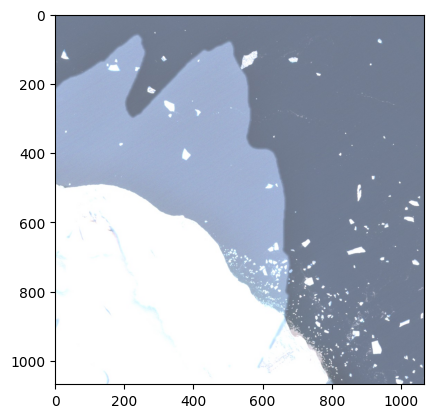

In [ ]:
plt.imshow(get_tile_thumbnail(row).permute(1, 2, 0))

In [ ]:
# test 3 Green!
row = 1857157
(lat1, lon1), (lat2, lon2) = calculate_bounding_box(gdf['centre_lat'].iloc[row], gdf['centre_lon'].iloc[row], gdf['grid_row_u'].iloc[row], gdf['grid_col_r'].iloc[row])
print(lat1, lon1, lat2, lon2)
r, map = get_forest_ratio(lat1, lon1, lat2, lon2, gdf['timestamp'].iloc[row], True)
print(r)
map

53.710656812668354 41.95502512242886 53.62083645338692 42.10647653176836
total pixels: 268709
forest pixels: 243815.0039215724
0.9073570439455784


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

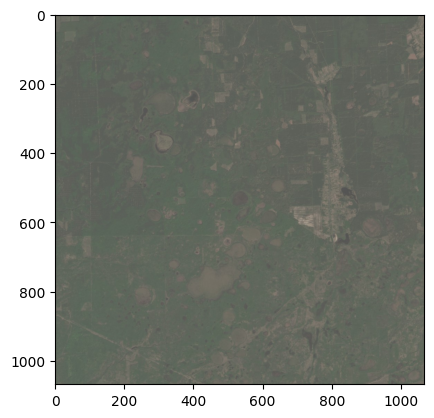

In [ ]:
plt.imshow(get_tile_thumbnail(row).permute(1, 2, 0))

# Adding column of forest ratio to the metadata and exporting it!

In [ ]:
from tqdm.auto import tqdm
def get_ratio_from_metadata_row(gdf, row, pbar = None):
  (lat1, lon1), (lat2, lon2) = calculate_bounding_box(gdf['centre_lat'].iloc[row], gdf['centre_lon'].iloc[row], gdf['grid_row_u'].iloc[row], gdf['grid_col_r'].iloc[row])
  ratio = get_forest_ratio(lat1, lon1, lat2, lon2, gdf['timestamp'].iloc[row])
  if pbar is not None:
    pbar.update(1)
  return ratio

In [ ]:
pbar = tqdm(total=len(gdf))
%timeit get_ratio_from_metadata_row(gdf, 152047, pbar)
pbar.reset()

  0%|          | 0/2245886 [00:00<?, ?it/s]

The slowest run took 7.16 times longer than the fastest. This could mean that an intermediate result is being cached.
270 ms ± 185 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 15.2 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=6ce63f3a27db9e37faf6a8b1de5961b97e5b398a669e5c64d6e224afff4be504
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [ ]:
# prompt: split in sequence gdf into 3 smaller tables 0.1:0.6:0.3

# Calculate split points
split1 = int(0.1 * len(gdf))
split2 = int(0.7 * len(gdf))

# Split the DataFrame
gdf_colab = gdf.iloc[:split1]
gdf_local = gdf.iloc[split1:split2]
gdf_kaggle = gdf.iloc[split2:]

# Print shapes for verification
print(gdf_colab.shape, gdf_local.shape, gdf_kaggle.shape)

(224588, 13) (1347532, 13) (673766, 13)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import swifter, time
from google.colab import files
def start_cooking(df, n = 10, start_i = 0, end_i = None, name = 'colab'):
  if end_i is None:
    end_i = n
  for i in tqdm(range(start_i, end_i)):
    # split the gdf_colab into n pieces and get the ith piece
    gdf_current = df.iloc[i*int(len(df)/n):min(len(df)-1, (i+1)*int(len(df)/n))]
    pbar = tqdm(total=len(gdf_current))
    gdf_current['forest_ratio'] = gdf_current.apply(lambda row: get_ratio_from_metadata_row(gdf, row.name, pbar), axis=1)
    assert('forest_ratio' in gdf_current.columns)
    gdf_current.to_feather(f'./drive/MyDrive/Major-TOM_metadata_with_forest_ratio/metadata_with_forest_ratio_{name}_{i}.feather')
    #files.download(f'./data/Major-TOM/metadata_with_forest_ratio_colab_{i}.feather') #download as you're done with it
    pbar.reset()

In [ ]:
start_cooking(gdf_kaggle, 100, 96, name='kaggle')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6737 [00:00<?, ?it/s]

  0%|          | 0/6737 [00:00<?, ?it/s]

  0%|          | 0/6737 [00:00<?, ?it/s]

  0%|          | 0/6737 [00:00<?, ?it/s]

# **Extras**

In [ ]:
! pip install geedim

In [ ]:
import ee
import geemap
map = geemap.Map()
image = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF4').filterDate('2018-01-01', '2019-01-01').first()
geemap.download_ee_image(image, 'image.tif', region = ee.Geometry.BBox(-90, -180, 90, 180), scale = 25)
# We cannot download the whole image and process it locally. Over 600 GB for each image, of which there are 4 (for four years of FNF4)

# **Testing and exploring S1RTC**


In [1]:
!pip install leafmap datasets git+https://github.com/ESA-PhiLab/Major-TOM.git

  Cloning https://github.com/ESA-PhiLab/Major-TOM.git to /tmp/pip-req-build-zoxp8cyg
  Running command git clone --filter=blob:none --quiet https://github.com/ESA-PhiLab/Major-TOM.git /tmp/pip-req-build-zoxp8cyg
  Resolved https://github.com/ESA-PhiLab/Major-TOM.git to commit c7ef3440f29e314ae1c7dc564234693c7f0f9e99
  Preparing metadata (setup.py) ... done


Execute the cell twice the first time you run it

In [94]:
from pathlib import Path
import urllib.request
from majortom import *

SOURCE_DATASET = 'Major-TOM/Core-S1RTC' # Identify HF Dataset
DATASET_DIR = Path('./data/Major-TOM')
DATASET_DIR.mkdir(exist_ok=True, parents=True)
ACCESS_URL = 'https://huggingface.co/datasets/{}/resolve/main/metadata.parquet?download=true'.format(SOURCE_DATASET)
LOCAL_URL = DATASET_DIR / '{}_{}.parquet'.format(SOURCE_DATASET.split('/')[1], ACCESS_URL.split('.parquet')[0].split('/')[-1])

# download from server to local url

if os.path.exists(LOCAL_URL):
  print('File already exists')
  df = pd.read_parquet(LOCAL_URL)
  df['timestamp'] = pd.to_datetime(df.timestamp)
  gdf = gpd.GeoDataFrame(
      df, geometry=gpd.points_from_xy(df.centre_lon, df.centre_lat), crs=df.crs.iloc[0].replace("EPSG:EPSG:", "EPSG:")
  )
  gdf['crs'] = gdf['crs'].replace("EPSG:EPSG:", "EPSG:", regex = True)
else:
  gdf = metadata_from_url(ACCESS_URL, LOCAL_URL)

gdf_S1 = gdf

File already exists


In [95]:
gdf_S1

,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,nodata,orbit_state,centre_lat,centre_lon,crs,parquet_url,parquet_row,geometry
0,874D_289R,-874,289,S1B_IW_GRDH_1SDV_20191105T144246_20191105T1443...,2019-11-05 14:42:55,0.0,ascending,-78.457192,130.431908,EPSG:32752,https://huggingface.co/datasets/Major-TOM/Core...,0,POINT (130.432 -78.457)
1,873D_288R,-873,288,S1B_IW_GRDH_1SDV_20191105T144246_20191105T1443...,2019-11-05 14:42:55,0.0,ascending,-78.368444,129.017958,EPSG:32752,https://huggingface.co/datasets/Major-TOM/Core...,1,POINT (129.018 -78.368)
2,872D_357R,-872,357,S1A_IW_GRDH_1SDV_20191105T135314_20191105T1353...,2019-11-05 13:53:23,0.0,descending,-78.279023,158.499052,EPSG:32757,https://huggingface.co/datasets/Major-TOM/Core...,2,POINT (158.499 -78.279)
3,872D_367R,-872,367,S1B_IW_GRDH_1SDV_20191106T134409_20191106T1344...,2019-11-06 13:44:19,0.0,descending,-78.280250,162.938316,EPSG:32758,https://huggingface.co/datasets/Major-TOM/Core...,3,POINT (162.938 -78.280)
4,871D_307R,-871,307,S1A_IW_GRDH_1SDV_20191106T143450_20191106T1435...,2019-11-06 14:35:00,0.0,ascending,-78.188563,135.328427,EPSG:32753,https://huggingface.co/datasets/Major-TOM/Core...,4,POINT (135.328 -78.189)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469950,905U_157R,905,157,S1B_IW_GRDH_1SDV_20190510T012605_20190510T0126...,2019-05-10 01:26:20,0.0,descending,81.332134,93.257502,EPSG:32646,https://huggingface.co/datasets/Major-TOM/Core...,495,POINT (93.258 81.332)
1469951,905U_143R,905,143,S1B_IW_GRDH_1SDV_20190712T015043_20190712T0151...,2019-07-12 01:50:57,0.0,descending,81.333875,84.956105,EPSG:32645,https://huggingface.co/datasets/Major-TOM/Core...,496,POINT (84.956 81.334)
1469952,905U_153R,905,153,S1B_IW_GRDH_1SDV_20210324T012616_20210324T0126...,2021-03-24 01:26:31,0.0,descending,81.333934,90.876738,EPSG:32646,https://huggingface.co/datasets/Major-TOM/Core...,497,POINT (90.877 81.334)
1469953,905U_151R,905,151,S1B_IW_GRDH_1SDV_20190419T015038_20190419T0151...,2019-04-19 01:50:53,0.0,descending,81.330194,89.717084,EPSG:32645,https://huggingface.co/datasets/Major-TOM/Core...,498,POINT (89.717 81.330)


In [5]:
from pathlib import Path
import urllib.request
from majortom import *

SOURCE_DATASET = 'Major-TOM/Core-S2L2A' # Identify HF Dataset
DATASET_DIR = Path('./data/Major-TOM')
DATASET_DIR.mkdir(exist_ok=True, parents=True)
ACCESS_URL = 'https://huggingface.co/datasets/{}/resolve/main/metadata.parquet?download=true'.format(SOURCE_DATASET)
LOCAL_URL = DATASET_DIR / '{}_{}.parquet'.format(SOURCE_DATASET.split('/')[1], ACCESS_URL.split('.parquet')[0].split('/')[-1])

# download from server to local url
if os.path.exists(LOCAL_URL):
  print('File already exists')
  df = pd.read_parquet(LOCAL_URL)
  df['timestamp'] = pd.to_datetime(df.timestamp)
  gdf = gpd.GeoDataFrame(
      df, geometry=gpd.points_from_xy(df.centre_lon, df.centre_lat), crs=df.crs.iloc[0].replace("EPSG:EPSG:", "EPSG:")
  )
  gdf['crs'] = gdf['crs'].replace("EPSG:EPSG:", "EPSG:", regex = True)
gdf = metadata_from_url(ACCESS_URL, LOCAL_URL)

gdf_S2 = gdf

In [6]:
gdf_S2

,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,cloud_cover,nodata,centre_lat,centre_lon,crs,parquet_url,parquet_row,geometry
0,922D_249L,-922,-249,S2A_MSIL2A_20230119T161811_N0509_R111_T01CDJ_2...,2023-01-19 16:18:11,18.941737,0.000000,-82.770666,-178.200331,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,0,POINT (-178.200 -82.771)
1,922D_245L,-922,-245,S2B_MSIL2A_20181219T162339_N9999_R011_T01CEJ_2...,2018-12-19 16:23:39,22.742201,0.000000,-82.768451,-175.349546,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,1,POINT (-175.350 -82.768)
2,922D_244L,-922,-244,S2A_MSIL2A_20200119T155811_N9999_R025_T01CEJ_2...,2020-01-19 15:58:11,0.000000,0.000000,-82.767914,-174.636985,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,2,POINT (-174.637 -82.768)
3,922D_243L,-922,-243,S2A_MSIL2A_20210103T155811_N9999_R025_T01CEJ_2...,2021-01-03 15:58:11,3.769691,0.000000,-82.767385,-173.924477,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,3,POINT (-173.924 -82.767)
4,922D_242L,-922,-242,S2B_MSIL2A_20181220T155319_N9999_R025_T01CEJ_2...,2018-12-20 15:53:19,0.000000,0.000000,-82.766864,-173.212021,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,4,POINT (-173.212 -82.767)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245881,920U_112L,920,-112,S2B_MSIL2A_20220904T213039_N0400_R086_T17XNM_2...,2022-09-04 21:30:39,0.000000,0.000000,82.677347,-78.077006,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,495,POINT (-78.077 82.677)
2245882,920U_111L,920,-111,S2A_MSIL2A_20230417T213041_N0509_R086_T17XNM_2...,2023-04-17 21:30:41,0.000000,0.000000,82.676773,-77.372609,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,496,POINT (-77.373 82.677)
2245883,920U_110L,920,-110,S2A_MSIL2A_20200416T211031_N0500_R143_T17XNM_2...,2020-04-16 21:10:31,0.130192,0.000000,82.676194,-76.668268,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,497,POINT (-76.668 82.676)
2245884,920U_109L,920,-109,S2B_MSIL2A_20200816T210029_N0500_R100_T17XNM_2...,2020-08-16 21:00:29,0.002016,0.000252,82.675608,-75.963985,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,498,POINT (-75.964 82.676)


There is not any grid cell in S1 that is not in S2

In [7]:
len({i for i in gdf_S1['grid_cell']} - {i for i in gdf_S2['grid_cell']})

0

In [8]:
missing_in_S1 = {i for i in gdf_S2['grid_cell']} - {i for i in gdf_S1['grid_cell']}

In [ ]:
missing_in_S1

{'787U_255R',
 '779D_234R',
 '32U_1480R',
 '764D_365L',
 '872U_81R',
 '803D_221R',
 '744D_184R',
 '532U_1116R',
 '901U_124L',
 '823U_184R',
 '153U_1218R',
 '210U_545R',
 '865U_129R',
 '390U_603R',
 '177D_788L',
 '652U_456R',
 '546D_499R',
 '618D_210L',
 '4D_53R',
 '755D_662R',
 '877D_191L',
 '297U_1184L',
 '671U_281L',
 '213U_1200R',
 '14U_1921R',
 '237D_1318L',
 '874U_46R',
 '732U_59L',
 '879D_332R',
 '110D_156L',
 '48D_161L',
 '190D_1823L',
 '608D_254L',
 '524U_879L',
 '757D_265R',
 '92D_752R',
 '743U_260L',
 '828U_12L',
 '70U_1232R',
 '391U_1311L',
 '843U_286R',
 '629U_452L',
 '588D_378L',
 '185D_227R',
 '139D_1533L',
 '406U_201R',
 '662U_933R',
 '908U_101L',
 '123D_1663R',
 '13U_461L',
 '49D_1696R',
 '511U_746L',
 '164U_275R',
 '742U_550R',
 '917D_119L',
 '27D_792L',
 '363D_1402R',
 '324U_245R',
 '188D_466L',
 '200D_1504L',
 '76D_778R',
 '752U_536R',
 '29U_777R',
 '621D_198L',
 '643D_139L',
 '157D_1277R',
 '247D_1787L',
 '325U_214R',
 '259U_1345R',
 '82U_1669R',
 '717U_312L',
 '116

In [ ]:
# Extract row numbers from the set
row_numbers = []
for item in missing_in_S1:
  try:
    number = int(re.match(r"^\d+", item).group(0))
    if 'D' in item:
      number *= -1
    row_numbers.append(number)
  except:
    pass

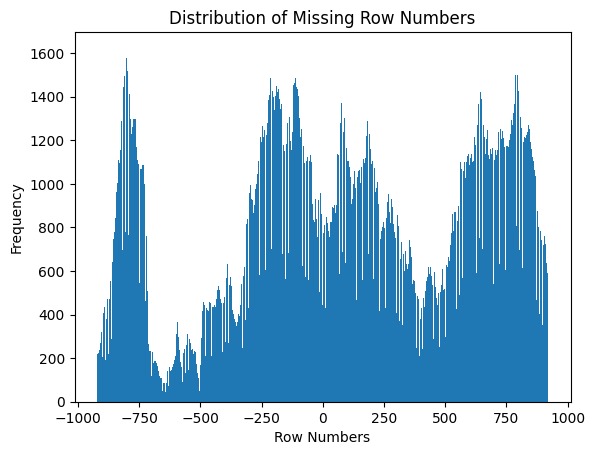

In [ ]:
import matplotlib.pyplot as plt
# Create a histogram
plt.hist(row_numbers, bins=1000)
plt.xlabel("Row Numbers")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Row Numbers")
plt.show()

In [ ]:
# Extract column numbers from the set
row_numbers = []
for item in missing_in_S1:
  try:
    item = item.split('_')[1]
    number = int(re.match(r"^\d+", item).group(0))
    if 'L' in item:
      number *= -1
    row_numbers.append(number)
  except:
    pass

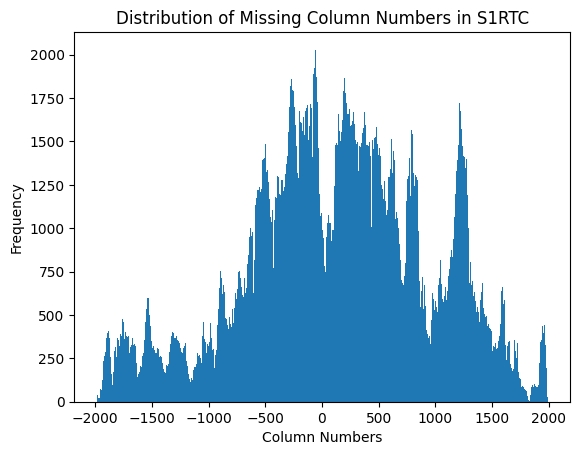

In [ ]:
import matplotlib.pyplot as plt
# Create a histogram
plt.hist(row_numbers, bins=1000)
plt.xlabel("Column Numbers")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Column Numbers in S1RTC")
plt.show()

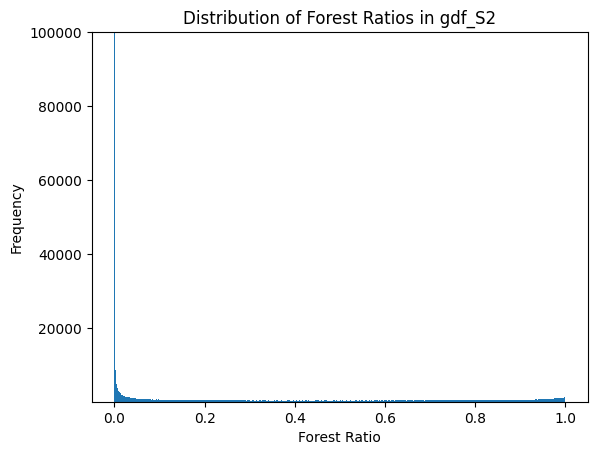

In [74]:
# prompt: distribution of forest_ratios across gdf_S2

# Assuming you have a DataFrame named 'gdf_S2' with a 'forest_ratio' column.
# If not, you'll need to load or create it first.

import matplotlib.pyplot as plt

# Plot the distribution of forest ratios
plt.hist(gdf_S2['forest_ratio'], bins=2000)  # Adjust the number of bins as needed
plt.xlabel('Forest Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Forest Ratios in gdf_S2')
#plt.yscale('log')
plt.ylim(1, 10**5)
plt.show()


# **Adding forest ratio to S1RTC metadata too**



In [9]:
METADATA_WITH_FOREST_RATIO_S2L2A = '/content/drive/MyDrive/Preparing Dataset/metadata_S2L2A_with_forest_ratio.parquet'

In [97]:
df = pd.read_parquet(METADATA_WITH_FOREST_RATIO_S2L2A)
df['timestamp'] = pd.to_datetime(df.timestamp)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.centre_lon, df.centre_lat), crs=df.crs.iloc[0].replace("EPSG:EPSG:", "EPSG:"))
gdf['crs'] = gdf['crs'].replace("EPSG:EPSG:", "EPSG:", regex = True)

In [98]:
gdf_S2 = gdf
gdf_S2

,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,cloud_cover,nodata,centre_lat,centre_lon,crs,parquet_url,parquet_row,forest_ratio,geometry
0,922D_249L,-922,-249,S2A_MSIL2A_20230119T161811_N0509_R111_T01CDJ_2...,2023-01-19 16:18:11,18.941737,0.000000,-82.770666,-178.200331,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,0,0.0,POINT (-178.200 -82.771)
1,922D_245L,-922,-245,S2B_MSIL2A_20181219T162339_N9999_R011_T01CEJ_2...,2018-12-19 16:23:39,22.742201,0.000000,-82.768451,-175.349546,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,1,0.0,POINT (-175.350 -82.768)
2,922D_244L,-922,-244,S2A_MSIL2A_20200119T155811_N9999_R025_T01CEJ_2...,2020-01-19 15:58:11,0.000000,0.000000,-82.767914,-174.636985,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,2,0.0,POINT (-174.637 -82.768)
3,922D_243L,-922,-243,S2A_MSIL2A_20210103T155811_N9999_R025_T01CEJ_2...,2021-01-03 15:58:11,3.769691,0.000000,-82.767385,-173.924477,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,3,0.0,POINT (-173.924 -82.767)
4,922D_242L,-922,-242,S2B_MSIL2A_20181220T155319_N9999_R025_T01CEJ_2...,2018-12-20 15:53:19,0.000000,0.000000,-82.766864,-173.212021,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,4,0.0,POINT (-173.212 -82.767)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245881,920U_112L,920,-112,S2B_MSIL2A_20220904T213039_N0400_R086_T17XNM_2...,2022-09-04 21:30:39,0.000000,0.000000,82.677347,-78.077006,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,495,0.0,POINT (-78.077 82.677)
2245882,920U_111L,920,-111,S2A_MSIL2A_20230417T213041_N0509_R086_T17XNM_2...,2023-04-17 21:30:41,0.000000,0.000000,82.676773,-77.372609,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,496,0.0,POINT (-77.373 82.677)
2245883,920U_110L,920,-110,S2A_MSIL2A_20200416T211031_N0500_R143_T17XNM_2...,2020-04-16 21:10:31,0.130192,0.000000,82.676194,-76.668268,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,497,0.0,POINT (-76.668 82.676)
2245884,920U_109L,920,-109,S2B_MSIL2A_20200816T210029_N0500_R100_T17XNM_2...,2020-08-16 21:00:29,0.002016,0.000252,82.675608,-75.963985,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,498,0.0,POINT (-75.964 82.676)


In [99]:
gdf_S1

,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,nodata,orbit_state,centre_lat,centre_lon,crs,parquet_url,parquet_row,geometry
0,874D_289R,-874,289,S1B_IW_GRDH_1SDV_20191105T144246_20191105T1443...,2019-11-05 14:42:55,0.0,ascending,-78.457192,130.431908,EPSG:32752,https://huggingface.co/datasets/Major-TOM/Core...,0,POINT (130.432 -78.457)
1,873D_288R,-873,288,S1B_IW_GRDH_1SDV_20191105T144246_20191105T1443...,2019-11-05 14:42:55,0.0,ascending,-78.368444,129.017958,EPSG:32752,https://huggingface.co/datasets/Major-TOM/Core...,1,POINT (129.018 -78.368)
2,872D_357R,-872,357,S1A_IW_GRDH_1SDV_20191105T135314_20191105T1353...,2019-11-05 13:53:23,0.0,descending,-78.279023,158.499052,EPSG:32757,https://huggingface.co/datasets/Major-TOM/Core...,2,POINT (158.499 -78.279)
3,872D_367R,-872,367,S1B_IW_GRDH_1SDV_20191106T134409_20191106T1344...,2019-11-06 13:44:19,0.0,descending,-78.280250,162.938316,EPSG:32758,https://huggingface.co/datasets/Major-TOM/Core...,3,POINT (162.938 -78.280)
4,871D_307R,-871,307,S1A_IW_GRDH_1SDV_20191106T143450_20191106T1435...,2019-11-06 14:35:00,0.0,ascending,-78.188563,135.328427,EPSG:32753,https://huggingface.co/datasets/Major-TOM/Core...,4,POINT (135.328 -78.189)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469950,905U_157R,905,157,S1B_IW_GRDH_1SDV_20190510T012605_20190510T0126...,2019-05-10 01:26:20,0.0,descending,81.332134,93.257502,EPSG:32646,https://huggingface.co/datasets/Major-TOM/Core...,495,POINT (93.258 81.332)
1469951,905U_143R,905,143,S1B_IW_GRDH_1SDV_20190712T015043_20190712T0151...,2019-07-12 01:50:57,0.0,descending,81.333875,84.956105,EPSG:32645,https://huggingface.co/datasets/Major-TOM/Core...,496,POINT (84.956 81.334)
1469952,905U_153R,905,153,S1B_IW_GRDH_1SDV_20210324T012616_20210324T0126...,2021-03-24 01:26:31,0.0,descending,81.333934,90.876738,EPSG:32646,https://huggingface.co/datasets/Major-TOM/Core...,497,POINT (90.877 81.334)
1469953,905U_151R,905,151,S1B_IW_GRDH_1SDV_20190419T015038_20190419T0151...,2019-04-19 01:50:53,0.0,descending,81.330194,89.717084,EPSG:32645,https://huggingface.co/datasets/Major-TOM/Core...,498,POINT (89.717 81.330)


In [100]:
# prompt: print rows with duplicate 'grid_cell' values in gdf_S1, gdf_S2, and gdf_S1_with_forest_ratio

# Find rows with duplicate 'grid_cell' values in gdf_S1
duplicate_grid_cells_S1 = gdf_S1[gdf_S1.duplicated(subset=['grid_cell'], keep=False)]
print("Duplicate 'grid_cell' rows in gdf_S1:")
display(duplicate_grid_cells_S1)

# Find rows with duplicate 'grid_cell' values in gdf_S2
duplicate_grid_cells_S2 = gdf_S2[gdf_S2.duplicated(subset=['grid_cell'], keep=False)]
print("\nDuplicate 'grid_cell' rows in gdf_S2:")
display(duplicate_grid_cells_S2)


Duplicate 'grid_cell' rows in gdf_S1:


,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,nodata,orbit_state,centre_lat,centre_lon,crs,parquet_url,parquet_row,geometry
270,631D_397L,-631,-397,S1B_IW_GRDH_1SDV_20200928T090419_20200928T0904...,2020-09-28 09:04:33,0.0,descending,-56.632970,-64.820907,EPSG:32720,https://huggingface.co/datasets/Major-TOM/Core...,270,POINT (-64.821 -56.633)
272,631D_397L,-631,-397,S1B_IW_GRDH_1SDV_20200928T090419_20200928T0904...,2020-09-28 09:04:33,0.0,descending,-56.632970,-64.820907,EPSG:32720,https://huggingface.co/datasets/Major-TOM/Core...,272,POINT (-64.821 -56.633)
542,619D_419L,-619,-419,S1A_IW_GRDH_1SDV_20220909T234655_20220909T2347...,2022-09-09 23:47:09,0.0,ascending,-55.552336,-66.519583,EPSG:32719,https://huggingface.co/datasets/Major-TOM/Core...,42,POINT (-66.520 -55.552)
544,619D_419L,-619,-419,S1A_IW_GRDH_1SDV_20220909T234655_20220909T2347...,2022-09-09 23:47:09,0.0,ascending,-55.552336,-66.519583,EPSG:32719,https://huggingface.co/datasets/Major-TOM/Core...,44,POINT (-66.520 -55.552)
892,612D_426L,-612,-426,S1A_IW_GRDH_1SDV_20200428T234635_20200428T2347...,2020-04-28 23:46:49,0.0,ascending,-54.923634,-66.573953,EPSG:32719,https://huggingface.co/datasets/Major-TOM/Core...,392,POINT (-66.574 -54.924)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468337,870U_44R,870,44,S1A_IW_GRDH_1SDV_20180913T061524_20180913T0615...,2018-09-13 06:15:37,0.0,descending,78.185068,19.457224,EPSG:32633,https://huggingface.co/datasets/Major-TOM/Core...,382,POINT (19.457 78.185)
1468602,874U_232R,874,232,S1B_IW_GRDH_1SDV_20200627T003726_20200627T0037...,2020-06-27 00:37:41,0.0,descending,78.543252,104.776402,EPSG:32647,https://huggingface.co/datasets/Major-TOM/Core...,147,POINT (104.776 78.543)
1468606,874U_232R,874,232,S1B_IW_GRDH_1SDV_20200627T003726_20200627T0037...,2020-06-27 00:37:41,0.0,descending,78.543252,104.776402,EPSG:32647,https://huggingface.co/datasets/Major-TOM/Core...,151,POINT (104.776 78.543)
1469592,895U_32R,895,32,S1B_IW_GRDH_1SDV_20190529T061414_20190529T0614...,2019-05-29 06:14:28,0.0,descending,80.436760,17.445374,EPSG:32634,https://huggingface.co/datasets/Major-TOM/Core...,137,POINT (17.445 80.437)



Duplicate 'grid_cell' rows in gdf_S2:


,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,cloud_cover,nodata,centre_lat,centre_lon,crs,parquet_url,parquet_row,forest_ratio,geometry
667,917D_239R,-917,239,S2A_MSIL2A_20160116T193712_N0201_R113_T57CWJ_2...,2016-01-16 19:37:12,0.000000,1.0,-82.318521,161.746594,EPSG:32757,https://huggingface.co/datasets/Major-TOM/Core...,167,0.0,POINT (161.747 -82.319)
668,917D_239R,-917,239,S2B_MSIL2A_20201023T174439_N0500_R069_T57CWJ_2...,2020-10-23 17:44:39,0.431957,0.0,-82.318521,161.746594,EPSG:32757,https://huggingface.co/datasets/Major-TOM/Core...,168,0.0,POINT (161.747 -82.319)
1819,907D_75L,-907,-75,S2B_MSIL2A_20211016T083939_N0301_R035_T23CMK_2...,2021-10-16 08:39:39,15.424540,0.0,-81.422448,-45.075915,EPSG:32723,https://huggingface.co/datasets/Major-TOM/Core...,319,0.0,POINT (-45.076 -81.422)
1820,907D_75L,-907,-75,S2B_MSIL2A_20221204T081929_N0400_R092_T23CMK_2...,2022-12-04 08:19:29,23.754629,0.0,-81.422448,-45.075915,EPSG:32723,https://huggingface.co/datasets/Major-TOM/Core...,320,0.0,POINT (-45.076 -81.422)
1976,906D_58L,-906,-58,S2B_MSIL2A_20220124T083939_N0301_R035_T25CDK_2...,2022-01-24 08:39:39,0.000000,0.0,-81.333697,-34.436068,EPSG:32725,https://huggingface.co/datasets/Major-TOM/Core...,476,0.0,POINT (-34.436 -81.334)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244700,916U_132L,916,-132,S2A_MSIL2A_20200913T211111_N0500_R143_T15XWM_2...,2020-09-13 21:11:11,0.000000,0.0,82.316187,-87.801513,EPSG:32615,https://huggingface.co/datasets/Major-TOM/Core...,314,0.0,POINT (-87.802 82.316)
2245200,917U_85R,917,85,S2A_MSIL2A_20220521T115651_N9999_R066_T40XES_2...,2022-05-21 11:56:51,0.000000,0.0,82.409608,57.752339,EPSG:32640,https://huggingface.co/datasets/Major-TOM/Core...,314,0.0,POINT (57.752 82.410)
2245201,917U_85R,917,85,S2A_MSIL2A_20200802T120651_N9999_R109_T40XES_2...,2020-08-02 12:06:51,0.000000,0.0,82.409608,57.752339,EPSG:32640,https://huggingface.co/datasets/Major-TOM/Core...,315,0.0,POINT (57.752 82.410)
2245207,917U_91R,917,91,S2B_MSIL2A_20190415T120649_N9999_R109_T40XES_2...,2019-04-15 12:06:49,0.000000,0.0,82.406318,61.827438,EPSG:32640,https://huggingface.co/datasets/Major-TOM/Core...,321,0.0,POINT (61.827 82.406)


In [102]:
# THIS IS PROBLEMATIC. ADDS DUPLICATE ROWS DUE TO NATURE OF SQL LEFT JOIN
'''# prompt: make a new column forest_ratio and set all it's value equal to corresponding forest_ratio (where grid_cell value matches)

# Merge the DataFrames based on 'grid_cell'
merged_df = pd.merge(gdf_S1, gdf_S2[['grid_cell', 'forest_ratio']], on='grid_cell', how='left')

# Rename the 'forest_ratio_y' column to 'forest_ratio'
merged_df.rename(columns={'forest_ratio': 'forest_ratio'}, inplace=True)

# Now, gdf_S1 has the 'forest_ratio' column with values corresponding to matching 'grid_cell'
gdf_S1_with_forest_ratio = merged_df'''

gdf_S2_dr = gdf_S2.drop_duplicates(subset=['grid_cell'], keep='first')
merged_df = pd.merge(gdf_S2[['grid_cell', 'forest_ratio']], gdf_S1, on='grid_cell', how='inner')
merged_df.rename(columns={'forest_ratio': 'forest_ratio'}, inplace=True)
gdf_S1_with_forest_ratio = merged_df

In [103]:
gdf_S1_with_forest_ratio

,grid_cell,forest_ratio,grid_row_u,grid_col_r,product_id,timestamp,nodata,orbit_state,centre_lat,centre_lon,crs,parquet_url,parquet_row,geometry
0,874D_289R,0.0,-874,289,S1B_IW_GRDH_1SDV_20191105T144246_20191105T1443...,2019-11-05 14:42:55,0.0,ascending,-78.457192,130.431908,EPSG:32752,https://huggingface.co/datasets/Major-TOM/Core...,0,POINT (130.432 -78.457)
1,873D_288R,0.0,-873,288,S1B_IW_GRDH_1SDV_20191105T144246_20191105T1443...,2019-11-05 14:42:55,0.0,ascending,-78.368444,129.017958,EPSG:32752,https://huggingface.co/datasets/Major-TOM/Core...,1,POINT (129.018 -78.368)
2,872D_357R,0.0,-872,357,S1A_IW_GRDH_1SDV_20191105T135314_20191105T1353...,2019-11-05 13:53:23,0.0,descending,-78.279023,158.499052,EPSG:32757,https://huggingface.co/datasets/Major-TOM/Core...,2,POINT (158.499 -78.279)
3,872D_367R,0.0,-872,367,S1B_IW_GRDH_1SDV_20191106T134409_20191106T1344...,2019-11-06 13:44:19,0.0,descending,-78.280250,162.938316,EPSG:32758,https://huggingface.co/datasets/Major-TOM/Core...,3,POINT (162.938 -78.280)
4,871D_307R,0.0,-871,307,S1A_IW_GRDH_1SDV_20191106T143450_20191106T1435...,2019-11-06 14:35:00,0.0,ascending,-78.188563,135.328427,EPSG:32753,https://huggingface.co/datasets/Major-TOM/Core...,4,POINT (135.328 -78.189)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480062,905U_151R,0.0,905,151,S1B_IW_GRDH_1SDV_20190419T015038_20190419T0151...,2019-04-19 01:50:53,0.0,descending,81.330194,89.717084,EPSG:32645,https://huggingface.co/datasets/Major-TOM/Core...,498,POINT (89.717 81.330)
1480063,905U_152R,0.0,905,152,S1B_IW_GRDH_1SDV_20190721T012610_20190721T0126...,2019-07-21 01:26:24,0.0,descending,81.334372,90.281469,EPSG:32646,https://huggingface.co/datasets/Major-TOM/Core...,499,POINT (90.281 81.334)
1480064,905U_153R,0.0,905,153,S1B_IW_GRDH_1SDV_20210324T012616_20210324T0126...,2021-03-24 01:26:31,0.0,descending,81.333934,90.876738,EPSG:32646,https://huggingface.co/datasets/Major-TOM/Core...,497,POINT (90.877 81.334)
1480065,905U_155R,0.0,905,155,S1B_IW_GRDH_1SDV_20210722T012622_20210722T0126...,2021-07-22 01:26:37,0.0,descending,81.333044,92.067184,EPSG:32646,https://huggingface.co/datasets/Major-TOM/Core...,494,POINT (92.067 81.333)


In [104]:
# Find rows with duplicate 'grid_cell' values in gdf_S1_with_forest_ratio
duplicate_grid_cells_S1_with_forest_ratio = gdf_S1_with_forest_ratio[gdf_S1_with_forest_ratio.duplicated(subset=['grid_cell'], keep=False)]
print("\nDuplicate 'grid_cell' rows in gdf_S1_with_forest_ratio:")
display(duplicate_grid_cells_S1_with_forest_ratio)


Duplicate 'grid_cell' rows in gdf_S1_with_forest_ratio:


,grid_cell,forest_ratio,grid_row_u,grid_col_r,product_id,timestamp,nodata,orbit_state,centre_lat,centre_lon,crs,parquet_url,parquet_row,geometry
193,793D_50R,0.0,-793,50,S1B_IW_GRDH_1SDV_20190125T023355_20190125T0234...,2019-01-25 02:34:06,0.0,descending,-71.183444,14.094761,EPSG:32733,https://huggingface.co/datasets/Major-TOM/Core...,193,POINT (14.095 -71.183)
194,793D_50R,0.0,-793,50,S1B_IW_GRDH_1SDV_20190125T023355_20190125T0234...,2019-01-25 02:34:06,0.0,descending,-71.183444,14.094761,EPSG:32733,https://huggingface.co/datasets/Major-TOM/Core...,193,POINT (14.095 -71.183)
273,631D_397L,0.0,-631,-397,S1B_IW_GRDH_1SDV_20200928T090419_20200928T0904...,2020-09-28 09:04:33,0.0,descending,-56.632970,-64.820907,EPSG:32720,https://huggingface.co/datasets/Major-TOM/Core...,270,POINT (-64.821 -56.633)
274,631D_397L,0.0,-631,-397,S1B_IW_GRDH_1SDV_20200928T090419_20200928T0904...,2020-09-28 09:04:33,0.0,descending,-56.632970,-64.820907,EPSG:32720,https://huggingface.co/datasets/Major-TOM/Core...,272,POINT (-64.821 -56.633)
275,631D_397L,0.0,-631,-397,S1B_IW_GRDH_1SDV_20200928T090419_20200928T0904...,2020-09-28 09:04:33,0.0,descending,-56.632970,-64.820907,EPSG:32720,https://huggingface.co/datasets/Major-TOM/Core...,270,POINT (-64.821 -56.633)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479710,895U_32R,0.0,895,32,S1B_IW_GRDH_1SDV_20190529T061414_20190529T0614...,2019-05-29 06:14:28,0.0,descending,80.436760,17.445374,EPSG:32634,https://huggingface.co/datasets/Major-TOM/Core...,143,POINT (17.445 80.437)
1479711,895U_32R,0.0,895,32,S1B_IW_GRDH_1SDV_20190529T061414_20190529T0614...,2019-05-29 06:14:28,0.0,descending,80.436760,17.445374,EPSG:32634,https://huggingface.co/datasets/Major-TOM/Core...,137,POINT (17.445 80.437)
1479712,895U_32R,0.0,895,32,S1B_IW_GRDH_1SDV_20190529T061414_20190529T0614...,2019-05-29 06:14:28,0.0,descending,80.436760,17.445374,EPSG:32634,https://huggingface.co/datasets/Major-TOM/Core...,143,POINT (17.445 80.437)
1479866,898U_164R,0.0,898,164,S1B_IW_GRDH_1SDV_20190721T012610_20190721T0126...,2019-07-21 01:26:24,0.0,descending,80.705124,90.957290,EPSG:32646,https://huggingface.co/datasets/Major-TOM/Core...,299,POINT (90.957 80.705)


Just testing to make sure it works

In [114]:
# prompt: randomly select 50 grid_cell values from the gdf_S1 dataset
# and print the corresponding forest_ratio in gdf_S1 and gdf_S2 and check

import random

# Randomly select 50 grid_cell values
selected_grid_cells = random.sample(list(gdf_S1['grid_cell'].unique()), 50)

# Print the corresponding forest_ratio in gdf_S1 and gdf_S2
for grid_cell in selected_grid_cells:
  forest_ratio_S1 = gdf_S1_with_forest_ratio.loc[gdf_S1_with_forest_ratio['grid_cell'] == grid_cell, 'forest_ratio'].iloc[0]
  forest_ratio_S2 = gdf_S2.loc[gdf_S2['grid_cell'] == grid_cell, 'forest_ratio'].iloc[0]
  print(f"Grid Cell: {grid_cell}, Forest Ratio (S1): {forest_ratio_S1}, Forest Ratio (S2): {forest_ratio_S2}", end = ' ')
  assert(forest_ratio_S1 == forest_ratio_S2)
  print('PASS')
print('All random tests passed!')

Grid Cell: 508U_502L, Forest Ratio (S1): 0.7674908774064808, Forest Ratio (S2): 0.7674908774064808 PASS
Grid Cell: 164D_504L, Forest Ratio (S1): 0.3984598010599139, Forest Ratio (S2): 0.3984598010599139 PASS
Grid Cell: 236D_689L, Forest Ratio (S1): 1.755217383672968e-05, Forest Ratio (S2): 1.755217383672968e-05 PASS
Grid Cell: 219U_1131L, Forest Ratio (S1): 0.0, Forest Ratio (S2): 0.0 PASS
Grid Cell: 343U_735R, Forest Ratio (S1): 0.40065831092982135, Forest Ratio (S2): 0.40065831092982135 PASS
Grid Cell: 40U_168R, Forest Ratio (S1): 1.0, Forest Ratio (S2): 1.0 PASS
Grid Cell: 74U_1290R, Forest Ratio (S1): 0.7508151755806568, Forest Ratio (S2): 0.7508151755806568 PASS
Grid Cell: 233U_974R, Forest Ratio (S1): 0.9661134257160038, Forest Ratio (S2): 0.9661134257160038 PASS
Grid Cell: 702U_163R, Forest Ratio (S1): 0.7935310505579316, Forest Ratio (S2): 0.7935310505579316 PASS
Grid Cell: 484U_1012L, Forest Ratio (S1): 0.0, Forest Ratio (S2): 0.0 PASS
Grid Cell: 134D_388R, Forest Ratio (S1): 

It works!

## Making a metadata file out gdf_S1 by reusing combiner code

In [ ]:
gdf_S1_with_forest_ratio = gdf_S1_with_forest_ratio.drop(columns=['geometry'])
gdf_S1_with_forest_ratio['timestamp'] = gdf_S1_with_forest_ratio['timestamp'].dt.strftime('%Y%m%dT%H%M%S')

In [ ]:
gdf_S1_with_forest_ratio.to_parquet('metadata_S1RTC_with_forest_ratio.parquet')

In [116]:
%timeit gdf_S1_with_forest_ratio[gdf_S1_with_forest_ratio['grid_cell'] == '92U_453R']

128 ms ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Testing new S1RTC metadata

In [ ]:
def load_metadata(path):
  '''
  Use this function to load metadata instead of the metadata_from_url(...) provided by Major-TOM mantainers
  '''
  df = pd.read_parquet(path)
  df['timestamp'] = pd.to_datetime(df.timestamp)
  gdf = gpd.GeoDataFrame(
      df, geometry=gpd.points_from_xy(df.centre_lon, df.centre_lat), crs=df.crs.iloc[0].replace("EPSG:EPSG:", "EPSG:")
  )
  return gdf

In [ ]:
S1_METADATA_PATH = '/content/drive/MyDrive/Preparing Dataset/metadata_S1RTC_with_forest_ratio.parquet'

In [ ]:
load_metadata(S1_METADATA_PATH)

,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,nodata,orbit_state,centre_lat,centre_lon,crs,parquet_url,parquet_row,forest_ratio,geometry
0,874D_289R,-874,289,S1B_IW_GRDH_1SDV_20191105T144246_20191105T1443...,2019-11-05 14:42:55,0.0,ascending,-78.457192,130.431908,EPSG:32752,https://huggingface.co/datasets/Major-TOM/Core...,0,0.0,POINT (130.432 -78.457)
1,873D_288R,-873,288,S1B_IW_GRDH_1SDV_20191105T144246_20191105T1443...,2019-11-05 14:42:55,0.0,ascending,-78.368444,129.017958,EPSG:32752,https://huggingface.co/datasets/Major-TOM/Core...,1,0.0,POINT (129.018 -78.368)
2,872D_357R,-872,357,S1A_IW_GRDH_1SDV_20191105T135314_20191105T1353...,2019-11-05 13:53:23,0.0,descending,-78.279023,158.499052,EPSG:32757,https://huggingface.co/datasets/Major-TOM/Core...,2,0.0,POINT (158.499 -78.279)
3,872D_367R,-872,367,S1B_IW_GRDH_1SDV_20191106T134409_20191106T1344...,2019-11-06 13:44:19,0.0,descending,-78.280250,162.938316,EPSG:32758,https://huggingface.co/datasets/Major-TOM/Core...,3,0.0,POINT (162.938 -78.280)
4,871D_307R,-871,307,S1A_IW_GRDH_1SDV_20191106T143450_20191106T1435...,2019-11-06 14:35:00,0.0,ascending,-78.188563,135.328427,EPSG:32753,https://huggingface.co/datasets/Major-TOM/Core...,4,0.0,POINT (135.328 -78.189)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480062,905U_157R,905,157,S1B_IW_GRDH_1SDV_20190510T012605_20190510T0126...,2019-05-10 01:26:20,0.0,descending,81.332134,93.257502,EPSG:32646,https://huggingface.co/datasets/Major-TOM/Core...,495,0.0,POINT (93.258 81.332)
1480063,905U_143R,905,143,S1B_IW_GRDH_1SDV_20190712T015043_20190712T0151...,2019-07-12 01:50:57,0.0,descending,81.333875,84.956105,EPSG:32645,https://huggingface.co/datasets/Major-TOM/Core...,496,0.0,POINT (84.956 81.334)
1480064,905U_153R,905,153,S1B_IW_GRDH_1SDV_20210324T012616_20210324T0126...,2021-03-24 01:26:31,0.0,descending,81.333934,90.876738,EPSG:32646,https://huggingface.co/datasets/Major-TOM/Core...,497,0.0,POINT (90.877 81.334)
1480065,905U_151R,905,151,S1B_IW_GRDH_1SDV_20190419T015038_20190419T0151...,2019-04-19 01:50:53,0.0,descending,81.330194,89.717084,EPSG:32645,https://huggingface.co/datasets/Major-TOM/Core...,498,0.0,POINT (89.717 81.330)


In [ ]:
load_metadata(METADATA_WITH_FOREST_RATIO_S2L2A)

,grid_cell,grid_row_u,grid_col_r,product_id,timestamp,cloud_cover,nodata,centre_lat,centre_lon,crs,parquet_url,parquet_row,forest_ratio,geometry
0,922D_249L,-922,-249,S2A_MSIL2A_20230119T161811_N0509_R111_T01CDJ_2...,2023-01-19 16:18:11,18.941737,0.000000,-82.770666,-178.200331,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,0,0.0,POINT (-178.200 -82.771)
1,922D_245L,-922,-245,S2B_MSIL2A_20181219T162339_N9999_R011_T01CEJ_2...,2018-12-19 16:23:39,22.742201,0.000000,-82.768451,-175.349546,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,1,0.0,POINT (-175.350 -82.768)
2,922D_244L,-922,-244,S2A_MSIL2A_20200119T155811_N9999_R025_T01CEJ_2...,2020-01-19 15:58:11,0.000000,0.000000,-82.767914,-174.636985,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,2,0.0,POINT (-174.637 -82.768)
3,922D_243L,-922,-243,S2A_MSIL2A_20210103T155811_N9999_R025_T01CEJ_2...,2021-01-03 15:58:11,3.769691,0.000000,-82.767385,-173.924477,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,3,0.0,POINT (-173.924 -82.767)
4,922D_242L,-922,-242,S2B_MSIL2A_20181220T155319_N9999_R025_T01CEJ_2...,2018-12-20 15:53:19,0.000000,0.000000,-82.766864,-173.212021,EPSG:32701,https://huggingface.co/datasets/Major-TOM/Core...,4,0.0,POINT (-173.212 -82.767)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245881,920U_112L,920,-112,S2B_MSIL2A_20220904T213039_N0400_R086_T17XNM_2...,2022-09-04 21:30:39,0.000000,0.000000,82.677347,-78.077006,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,495,0.0,POINT (-78.077 82.677)
2245882,920U_111L,920,-111,S2A_MSIL2A_20230417T213041_N0509_R086_T17XNM_2...,2023-04-17 21:30:41,0.000000,0.000000,82.676773,-77.372609,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,496,0.0,POINT (-77.373 82.677)
2245883,920U_110L,920,-110,S2A_MSIL2A_20200416T211031_N0500_R143_T17XNM_2...,2020-04-16 21:10:31,0.130192,0.000000,82.676194,-76.668268,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,497,0.0,POINT (-76.668 82.676)
2245884,920U_109L,920,-109,S2B_MSIL2A_20200816T210029_N0500_R100_T17XNM_2...,2020-08-16 21:00:29,0.002016,0.000252,82.675608,-75.963985,EPSG:32617,https://huggingface.co/datasets/Major-TOM/Core...,498,0.0,POINT (-75.964 82.676)
